In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib as mpl
from matplotlib import ticker
import seaborn as sns 
sys.path.append('/Users/omichel/Desktop/qilimanjaro/projects/scattering/domain_wall_scattering/src')

from DynamicsDefinition import Hamiltonian
from model_building import initialize_system
from dynamics import time_evolution, single_qubit_expectation_values, two_qubit_expectation_values
from plots import plot_V_and_T2_heatmap, plot_transmission_x_T2, plot_transmission_x_V
from data_handling import save_numpy_array, fetch_numpy_array

# Heat map of transmission as a function of potential barrier size and dephasing time

This notebook contains simulations and plots of a scattering experiment and it shows the different relevant magnitudes of the outcome:

- Min value of <Z> in the last qubit
- Fraction of transmission of excitation to the last qubit

We present it in different forms:

- 2D heatmap with all the data
- Plots with several curves corresponding to different barrier sizes or dephasings

Additionally, we do the simulations for uniform Heisenberg chains and perfect transport inhomogenous chains

## Parameter definition

For the Heisenberg chain

In [2]:
N = 5
lmd = 0.02272
J = 1

V_index = 3
state_dictionary = {'0':1}
ti = 0
tf = np.pi/lmd*1.5
nstep = 500
environment = True
Hamiltonian_type = 'diffusion'


V = np.linspace(0, 5*lmd, 11)
# T2 = np.linspace(10, 10000, 11)
T2 = np.exp(np.linspace(np.log(50), np.log(10000), 11))

min_z_last_qubit = np.zeros((len(T2), len(V)))


initial_state, final_state, reg_size = initialize_system(state_dictionary, N, encoding='domain_wall', one_step=False)


## Main loop

In [3]:
def simulate_V_and_T2_range(N, lmd, J, psi0, V_index, V_list, T2_list, env, H_type = 'diffusion', path='./'):
    #Create empty arrays for results
    min_z_last_qubit = np.zeros((len(T2), len(V)))
    fidelity_last_qubit = np.zeros((len(T2), len(V)))

    #Loop over all values of T2 and barrier height V

    H = Hamiltonian(N, lmd, J, 0., V_index, H_type)
    ideal_simulation = time_evolution(H, psi0, ti, tf, nstep, dephasing_rates = N*[0.], environment = False)

    for i, t2_i in enumerate(T2_list):

        #Calculate dephasing rates
        gamma = 1/t2_i
        dephasing_rates = N*[gamma]
        for j, pot_j in enumerate(V_list):

            #Generate Hamiltonian
            H = Hamiltonian(N, lmd, J, pot_j, V_index, H_type)

            #Evolve state
            simulation = time_evolution(H, psi0, ti, tf, nstep, dephasing_rates, env)

            #Calculate and store Z expectation values
            exp_values = single_qubit_expectation_values(simulation, H)
            #Store minimum Z of last qubit
            min_z_last_qubit[i, j] = min(exp_values['Sz'][:,-1])
            min_z_index = np.argmin(exp_values['Sz'][:,-1])

            #Calculate and store fidelities
            #We need to calculate fidelity of only last qubit at the time of min z
            fidelity_last_qubit[i, j] = qt.fidelity(simulation.states[min_z_index].ptrace(N-1), ideal_simulation.states[min_z_index].ptrace(N-1))

    #Save data
    extension = f'_V-{len(V_list)}_T-{len(T2_list)}_{H_type}'
    save_numpy_array(min_z_last_qubit, filepath = path + 'heatmap' + extension)
    save_numpy_array(fidelity_last_qubit, filepath = path + 'fidelity' + extension) 
    
    return min_z_last_qubit, fidelity_last_qubit

In [19]:
min_z_list, fidelity_list = simulate_V_and_T2_range(N, lmd, J, initial_state, V_index, V, T2, environment, Hamiltonian_type, 
                                                    path = '/Users/omichel/Desktop/qilimanjaro/projects/scattering/files/data/')

Data successfully saved to: /Users/omichel/Desktop/qilimanjaro/projects/scattering/files/data/heatmap_V-11_T-11_diffusion.npy
Data successfully saved to: /Users/omichel/Desktop/qilimanjaro/projects/scattering/files/data/fidelity_V-11_T-11_diffusion.npy


In [4]:
#Load data
filepath = "/Users/omichel/Desktop/qilimanjaro/projects/scattering/files/data/heatmap_V-11_T-11_diffusion"
min_z_last_qubit = fetch_numpy_array(filepath)

filepath = "/Users/omichel/Desktop/qilimanjaro/projects/scattering/files/data/fidelity_V-11_T-11_diffusion"
fidelity_last_qubit = fetch_numpy_array(filepath)

## Plot magnitudes

In [5]:
V_plot = V/lmd
T2_plot = T2/tf

def calculate_z_transmission(data):
    z_transmission = np.zeros((len(T2), len(V)))
    max_z_diff = 1 - min(data[-1])
    for i in range(len(data)):
        for j in range(len(data[i,:])):
            z_transmission[i,j] = ((1 - data[i,j])/max_z_diff)
    return z_transmission

z_transmission = calculate_z_transmission(min_z_last_qubit)



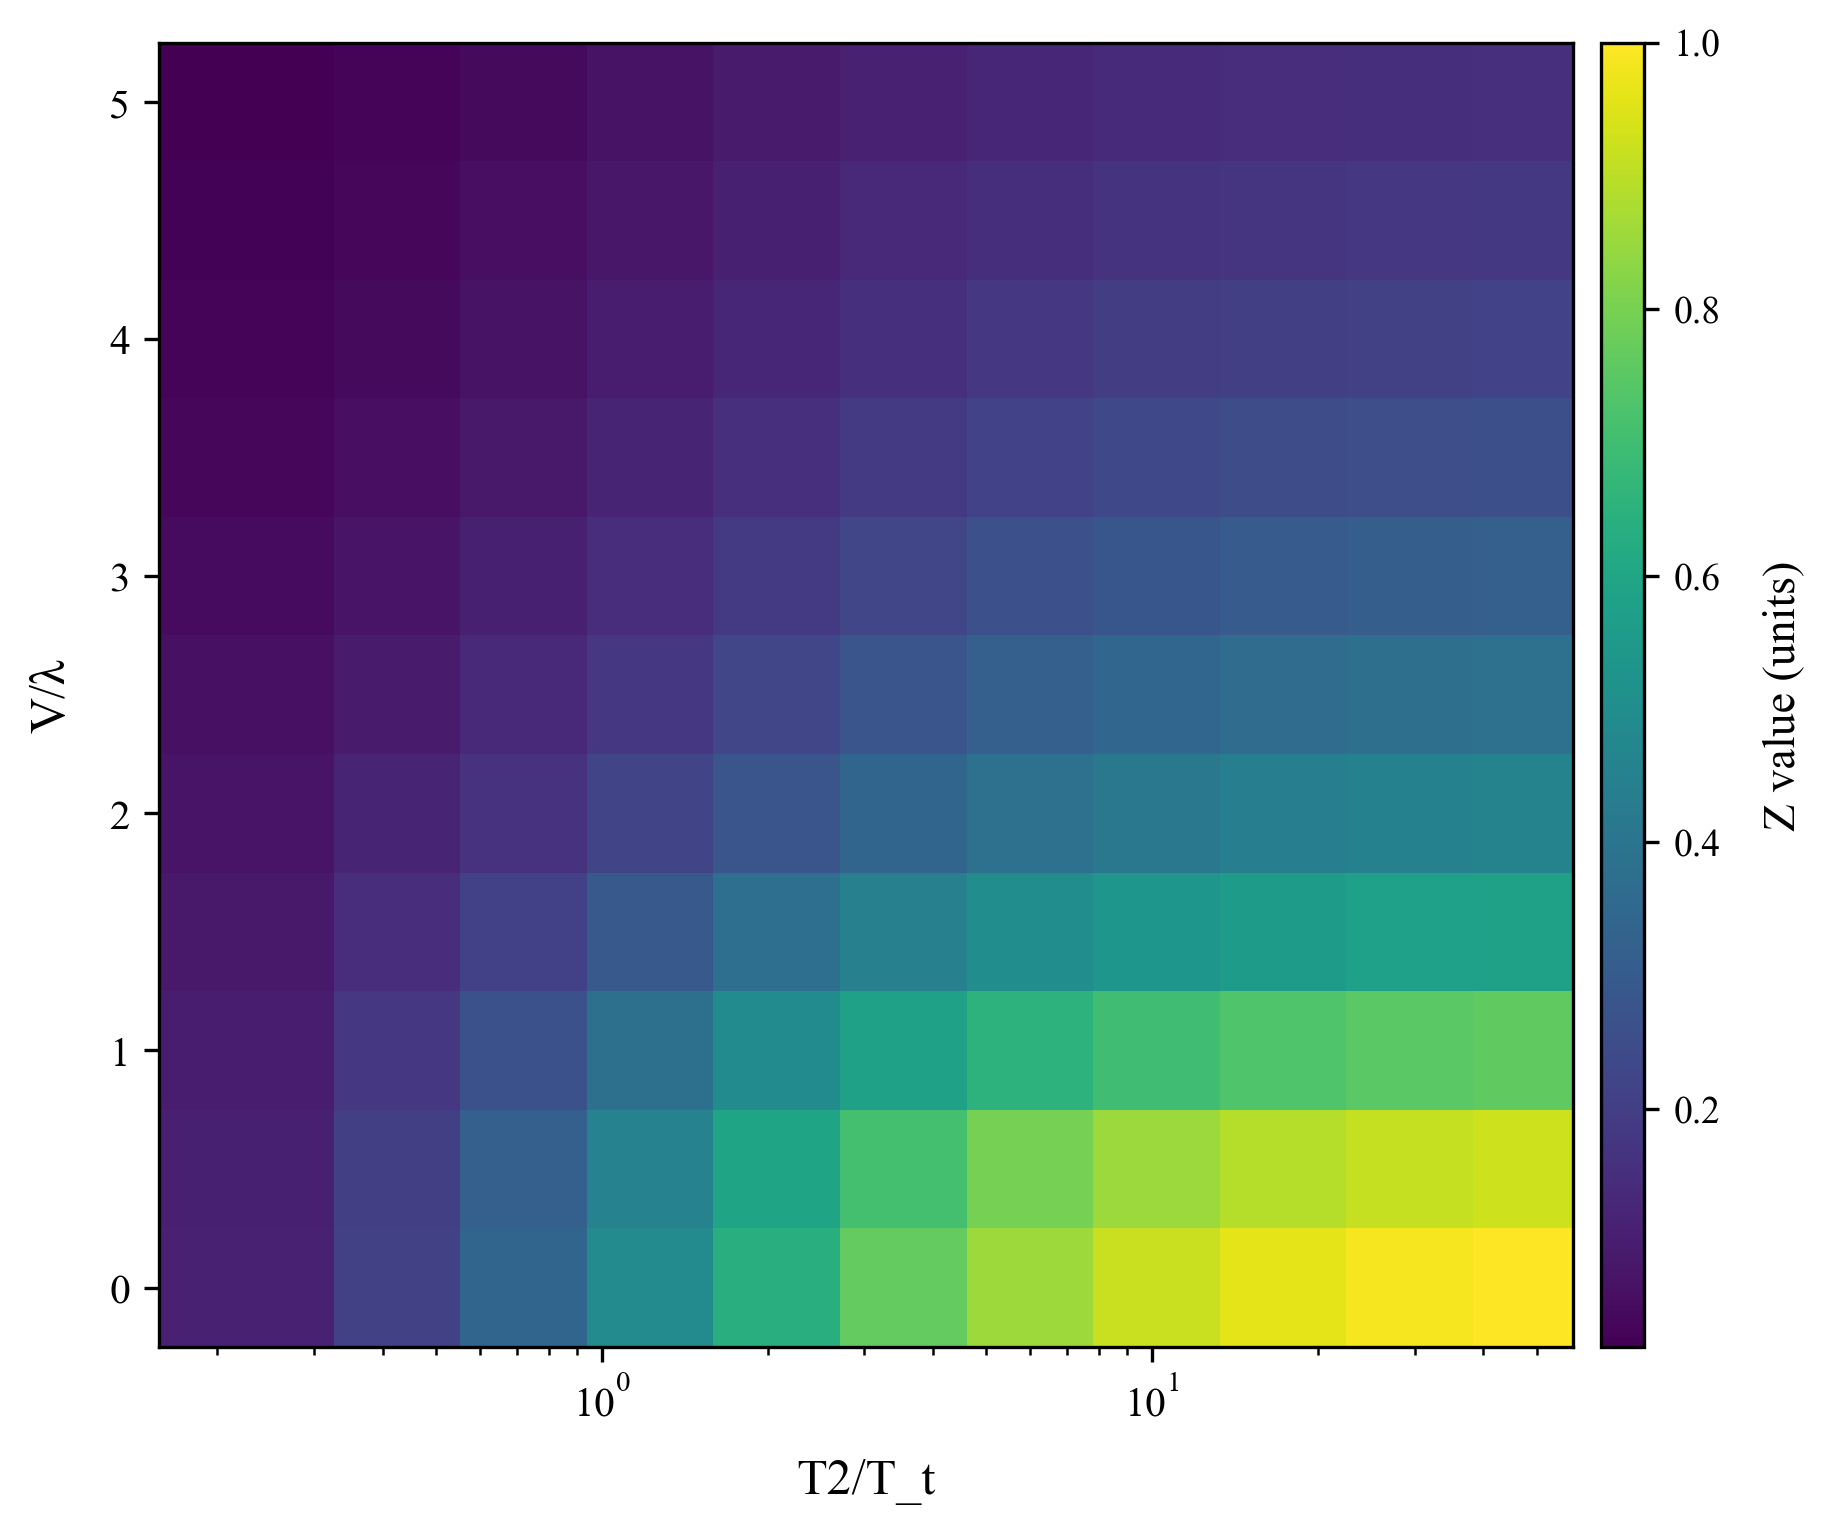

In [6]:
plot_V_and_T2_heatmap(V_plot, T2_plot, data=z_transmission)

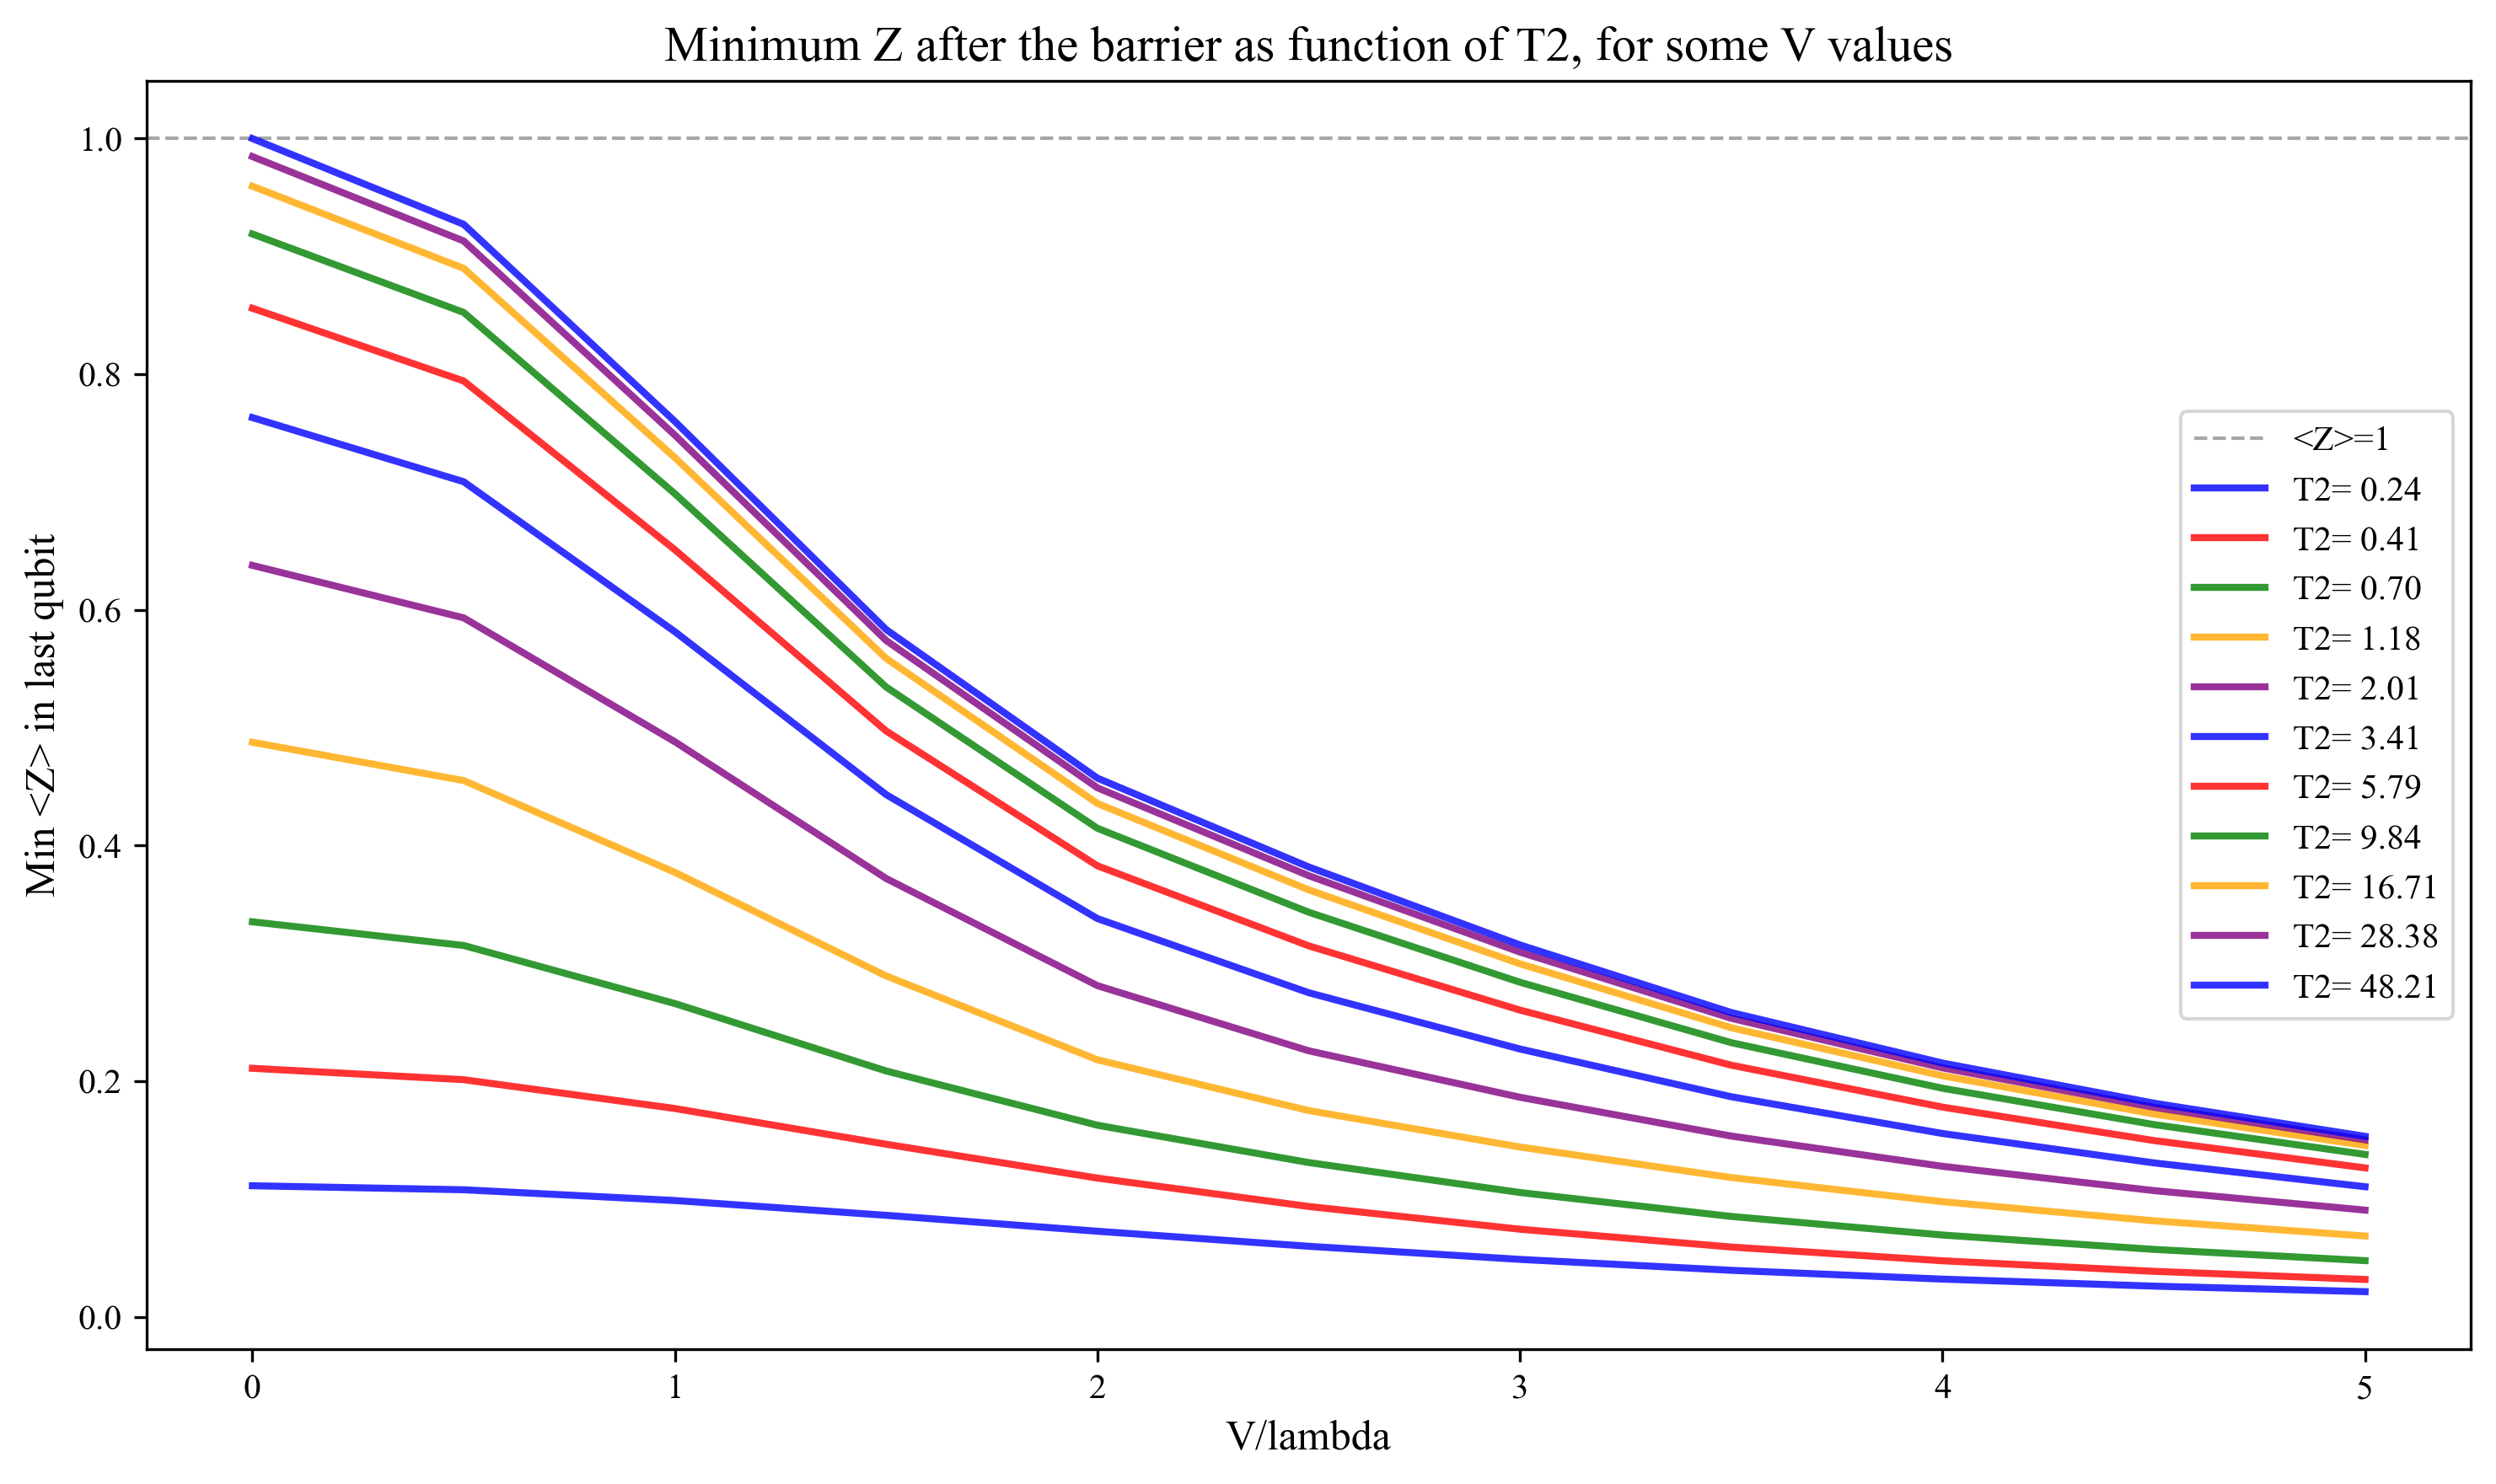

In [11]:
plot_transmission_x_V(v_values=V_plot, data=z_transmission, labels=T2_plot)

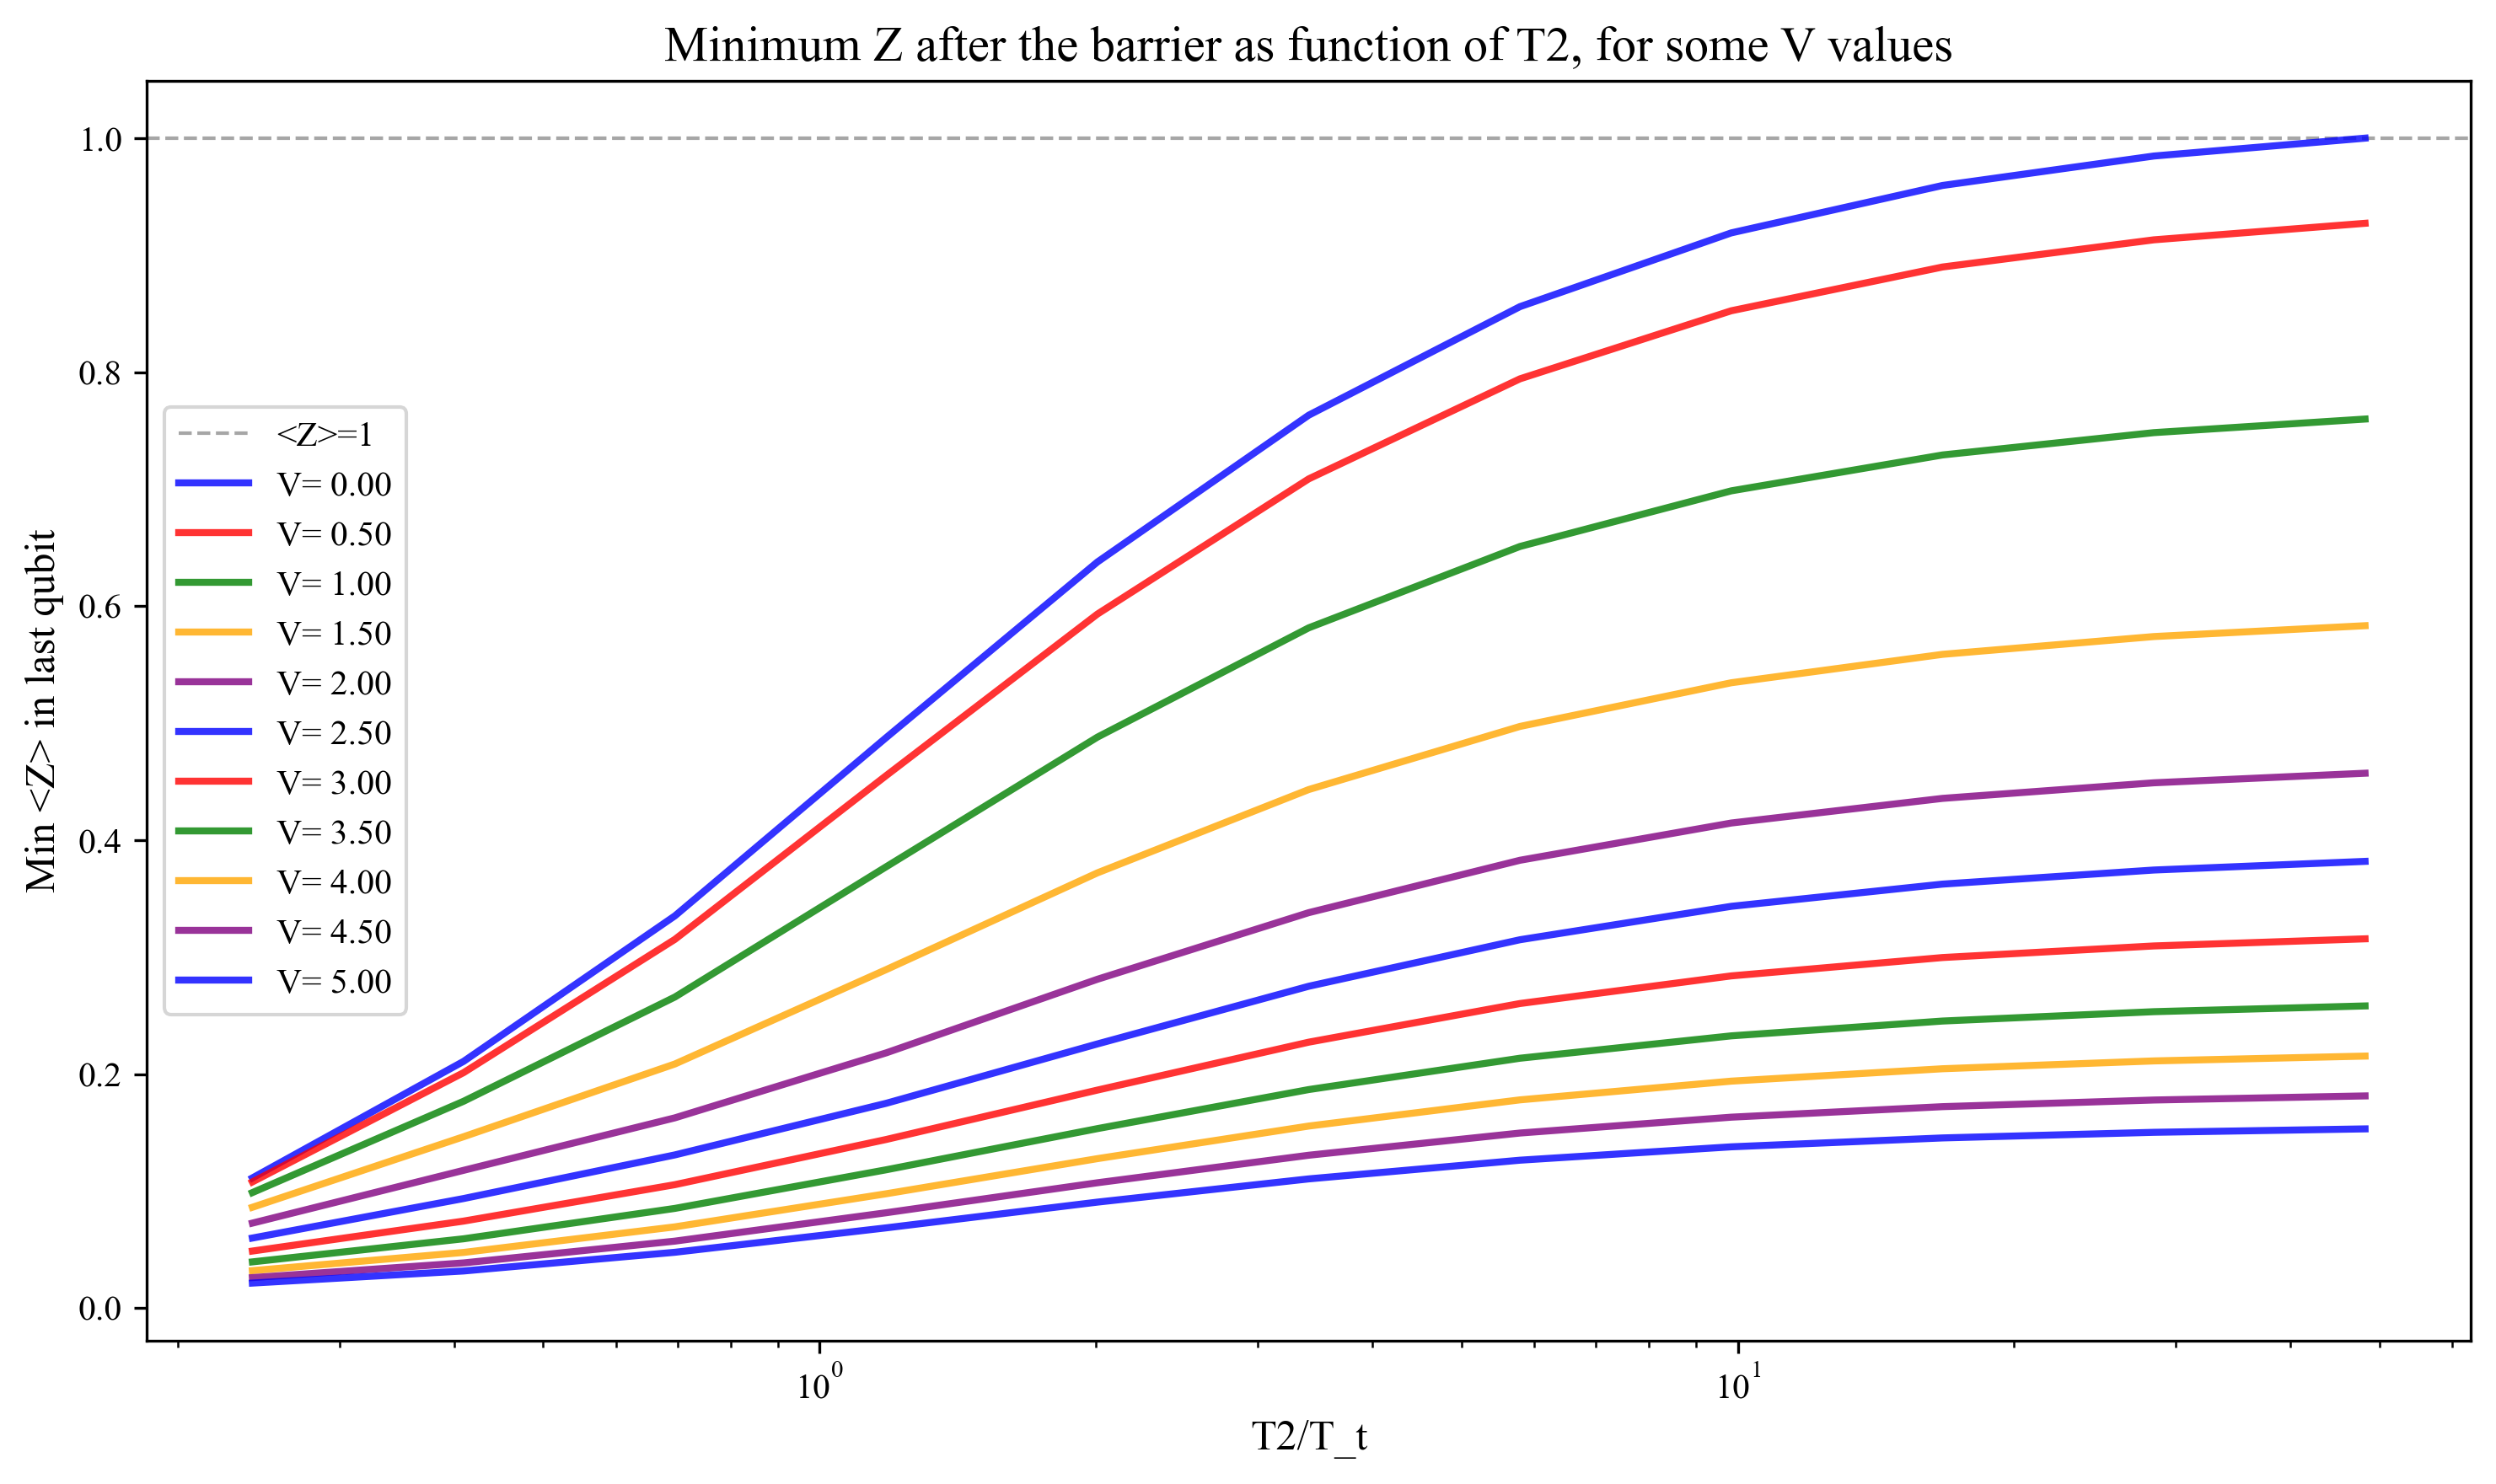

In [12]:
plot_transmission_x_T2(t_values=T2_plot, data=z_transmission, labels=V_plot)

## Plot configuration of heat map